# À propos de ce livret

Ceci est la méthode KPMF : 
* Ce qu'est KPMF;
* Comment implémenter KBMF en utilisant R;
* La manière de faire de l'imputation avec un jeu de données spatiotemporel.
Pour une compréhension en profondeur de la méthode, ainsi que les techniques de modélisation, voici les recherches liés au développement de la méthode : 

>Tinghui Zhou, Hanhuai Shan, Arindam Banerjee, Guillermo Sapiro (2012). **Kernelized probabilistic matrix factorization: exploiting graphs and side information.**


La méthode implantée provient des dépôts Github : 

[**Dépôt 1**](https://github.com/kastnerkyle/School/blob/master/atpr/matrix_factorization.py) *version python*
[**Dépôt 2**](https://github.com/sg3510/al_proj) *version matlab*




## Prêt-à-l'utilisation

Ce livret est disponible pour tout usage d'imputation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.cm as cm
# from scipy.misc import lena (non utilisé - À la base cet élément servait à générer des images)
from scipy.misc import ascent # au lieu de lena
import scipy.sparse as sp
import scipy.linalg as sl
#import numpy.linalg as sl

In [2]:
os.chdir("C:/Users/amass/OneDrive/02_Education/02_Maitrise/Cours/PROJET_MAITRISE/application")

## Model

In [ ]:
#!/usr/bin/python
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.cm as cm
from scipy.misc import lena
#To get the latest scipy (for banded matrix generation
#sudo apt-get install python python-dev gfortran libatlas-base-dev
#sudo pip install scipy
import scipy.sparse as sp
import scipy.linalg as sl
#Example from
#Singular Value Decomposition Tutorial
#Kirk Baker
#pg 17

#A = np.asarray([[3,1,1],[-1, 3, 1]])
#U,S,VT = np.linalg.svd(A, full_matrices=False)
#S = np.diag(S)
#A_ = np.dot(U, np.dot(S, VT))
#print np.allclose(A, A_)

def lowrank_SVD(input_matrix, approx=50):
    U,S,VT = np.linalg.svd(A, full_matrices=False)
    A_ = np.zeros((len(U), len(VT)))
    print "Running low rank SVD with:"
    print "approximation rank=" + `K`
    print ""
    for i in xrange(K):
        A_ += S[i]*np.outer(U.T[i],VT[i])
    return A_

def PMF(input_matrix, approx=50, iterations=30, learning_rate=.001, regularization_rate=.1):
    A = input_matrix
    Z = np.asarray(A > 0,dtype=np.int)
    A1d = np.ravel(A)
    mean = np.mean(A1d)
    #Remove DC term (mean), advice from
    #http://www.intelligentmining.com/2011/08/08/intro-to-matrix-factorization/
    A = A-mean
    K = approx
    R = itr = iterations
    l = learning_rate
    b = regularization_rate
    N = A.shape[0]
    M = A.shape[1]
    U = np.random.randn(N,K)
    V = np.random.randn(K,M)
    print "Running PMF with:"
    print "learning rate=" + `l`
    print "regularization rate=" + `b`
    print "approximation rank=" + `K`
    print "iterations=" + `R`
    print ""
    #PMF using gradient descent as per paper
    #Probabilistic Matrix Factorization
    #R. Salakhutdinov, A. Minh
    for r in range(R):
        for i in range(N):
            for j in range(M):
                if Z[i,j] > 0:
                    e = A[i,j] - np.dot(U[i,:],V[:,j])
                    U[i,:] = U[i,:] + l*(e*V[:,j] - b*U[i,:])
                    V[:,j] = V[:,j] + l*(e*U[i,:] - b*V[:,j])
    A_ = np.dot(U,V)
    return A_

def KPMF(input_matrix, approx=50, iterations=30, learning_rate=.001, adjacency_width=5, adjacency_strength=.5):
    A = input_matrix
    Z = np.asarray(A > 0,dtype=np.int)
    A1d = np.ravel(A)
    mean = np.mean(A1d)
    A = A-mean
    K = approx
    R = itr = iterations
    l = learning_rate
    N = A.shape[0]
    M = A.shape[1]
    U = np.random.randn(N,K)
    V = np.random.randn(K,M)
    #KPMF using gradient descent as per paper
    #Kernelized Probabilistic Matrix Factorization: Exploiting Graphs and Side Information
    #T. Zhou, H. Shan, A. Banerjee, G. Sapiro
    #Using diffusion kernel
    #U are the rows, we use an adjacency matrix CU to reprent connectivity
    #This matrix connects rows +-adjacency_width
    #V are the columns, connected columns are CV
    #Operate on graph laplacian L, which is the degree matrix D - C
    #Applying the diffusion kernel to L, this forms a spatial smoothness graph
    bw = adjacency_width
    #Use scipy.sparse.diags to generate band matrix with bandwidth = 2*adjacency_width+1
    #Example of adjacency_width = 1, N = 4
    #[1 1 0 0]
    #[1 1 1 0]
    #[0 1 1 1]
    #[0 0 1 1]
    print "Running KPMF with:"
    print "learning rate=" + `l`
    print "bandwidth=" + `bw`
    print "beta=" + `b`
    print "approximation rank=" + `K`
    print "iterations=" + `R`
    print ""
    CU = sp.diags([1]*(2*bw+1),range(-bw,bw+1),shape=(N,N)).todense()
    DU = np.diagflat(np.sum(CU,1))
    CV = sp.diags([1]*(2*bw+1),range(-bw,bw+1),shape=(M,M)).todense()
    DV = np.diagflat(np.sum(CV,1))
    LU = DU - CU
    LV = DV - CV
    beta = adjacency_strength
    KU = sl.expm(beta*LU)
    KV = sl.expm(beta*LV)
    SU = np.linalg.pinv(KU)
    SV = np.linalg.pinv(KV)
    for r in range(R):
        for i in range(N):
            for j in range(M):
                if Z[i,j] > 0:
                    e = A[i,j] - np.dot(U[i,:],V[:,j])
                    U[i,:] = U[i,:] + l*(e*V[:,j] - np.dot(SU[i,:],U))
                    V[:,j] = V[:,j] + l*(e*U[i,:] - np.dot(V,SV[:,j]))
    A_ = np.dot(U,V)
    return A_+mean

def get_RMSE(A,A_):
    A1d = np.ravel(A)
    A_1d = np.ravel(A_)
    e = np.mean((A1d-A_1d)**2)
    return np.sqrt(e)

def combine(A,A_):
    out = np.zeros(A.shape)
    N = A.shape[0]
    M = A.shape[1]
    for i in xrange(N):
        for j in xrange(M):
            if A[i,j] == 0:
                out[i,j] = A_[i,j]
            else:
                out[i,j] = A[i,j]
    return out

#Rework of lena example
#from https://gist.github.com/thearn/5424219
#Sparse lena
A = np.asarray(lena(),dtype=np.double)
plot.figure()
plot.title("Original Lena")
plot.imshow(A, cmap=cm.gray)
plot.savefig("pristine_lena.png")

#Full matrix SVD, low rank approximation
approx = K = 10
iterations = I = 7
origA = lena()
A_= lowrank_SVD(A,approx=K)
plot.figure()
RMSE = get_RMSE(origA,A_)
plot.title("Low Rank SVD (full matrix)\nRMSE=" + `RMSE`)
plot.imshow(A_, cmap=cm.gray)
plot.savefig("SVD_full_approx_"+`K`+".png")
plot.figure()
plot.title("Combined Low Rank SVD (full matrix)\nRMSE=" + `RMSE`)
plot.imshow(combine(A,A_), cmap=cm.gray)
plot.savefig("CombinedSVD_full_approx_"+`K`+".png")

#Make lena sparse matrix setup, sparseness is the percentage of deleted pixels
sparseness = .75
A = lena()
for i in xrange(A.shape[0]):
    for j in xrange(A.shape[1]):
        if np.random.rand() < sparseness:
            A[i,j] = 0.

#Sparse lena
plot.figure()
plot.title("Sparse Lena")
plot.imshow(A, cmap=cm.gray)
plot.savefig("sparse_lena_s_"+`sparseness`+".png")

#Sparse matrix, regular SVD example, low rank approximation
A_=lowrank_SVD(A,approx=K)
plot.figure()
RMSE = get_RMSE(origA,A_)
plot.title("Low Rank SVD\nRMSE="+`RMSE`)
plot.imshow(A_, cmap=cm.gray)
plot.savefig("SVD_sparse_approx_"+`K`+".png")
plot.figure()
plot.title("Combined Low Rank SVD\nRMSE="+`RMSE`)
plot.imshow(combine(A,A_), cmap=cm.gray)
plot.savefig("CombinedSVD_sparse_approx_"+`K`+".png")

#Keeping learning rate constant for all PMF examples
l = 0.001
#Sparse matrix, gradient descent example
#Save RMSE as tuple of two values, (b,RMSE)
PMF_RMSE=[]
for b in [0.,.25,.5,.75,1.]:
    A_=PMF(A,approx=K,iterations=I,regularization_rate=b,learning_rate=l)
    plot.figure()
    RMSE = get_RMSE(origA,A_)
    PMF_RMSE.append((b,RMSE))
    #Lambda is the regularization rate (lambda_v = lambda_u from the paper
    plot.title("PMF, $\lambda$=" + `b` + "\nRMSE=" + `RMSE`)
    plot.imshow(A_, cmap=cm.gray)
    plot.savefig("PMF_b_"+`int(10*b)`+".png")
    plot.figure()
    plot.title("Combined PMF, $\lambda$=" + `b` + "\nRMSE=" + `RMSE`)
    plot.imshow(combine(A,A_), cmap=cm.gray)
    plot.savefig("CombinedPMF_b_"+`int(10*b)`+".png")

#Sparse matrix, kernelized probabilistic matrix
#Save RMSE as tuple of 3 values (b,w,RMSE)
KPMF_RMSE=[]
for w in [0,4,10,20,40]:
    blist = []
    for b in [0.,.25,.5,.75,1.]:
        A_=KPMF(A,approx=K,iterations=I,adjacency_width=w,adjacency_strength=b,learning_rate=l)
        plot.figure()
        RMSE = get_RMSE(origA,A_)
        blist.append(RMSE)
        plot.title(r"Kernelized PMF, $\beta$=" + `b` + ", width=" + `w`+ "\nRMSE=" + `RMSE`)
        plot.imshow(A_, cmap=cm.gray)
        plot.savefig("KPMF_w"+`w`+"_b_"+`int(10*b)`+".png")
        plot.figure()
        plot.title(r"Combined KPMF, $\beta$=" + `b` + ", width=" + `w`+ "\nRMSE=" + `RMSE`)
        plot.imshow(combine(A,A_), cmap=cm.gray)
        plot.savefig("CombinedKPMF_w"+`w`+"_b_"+`int(10*b)`+".png")
    KPMF_RMSE.append((w,tuple(blist)))

colors=['r','b','g','c','m','k']
plot.figure()
bs,RMSEs = zip(*PMF_RMSE)
ws,bRMSEs = zip(*KPMF_RMSE)
labels=["PMF"]+["KPMF_"+`w` for w in ws]
plot.title("RMSE vs. regularization/diffusion rate")
for err,col,lbl in zip((RMSEs,)+bRMSEs,colors,labels):
    plot.plot(bs, err, col, label=str(lbl))
plot.xlabel('Regularization rate')
plot.ylabel('RMSE')
plot.legend()
plot.savefig("reg_rate_and_diffusion_RMSE.png")

plot.figure()
plot.title("Average RMSE vs. kernel bandwidth")
for err, col, lbl in zip(bRMSEs,
                         colors,
                         bs):
    plot.plot(ws, err, col, label=str(lbl))
plot.xlabel('Kernel bandwidth')
plot.ylabel('Average RMSE over calculated rates')
plot.legend()
plot.savefig("kernel_width_mean_RMSE.png")

# Partie 1 : Données

## Partie 2.1 : Spécification du modèle

In [ ]:
def KPMF(input_matrix, approx=50, iterations=30, learning_rate=.001, adjacency_width=5, adjacency_strength=.5):
    A = input_matrix
    Z = np.asarray(A > 0,dtype=np.int)
    A1d = np.ravel(A)
    mean = np.mean(A1d)
    A = A-mean
    K = approx
    R = itr = iterations
    l = learning_rate
    N = A.shape[0]
    M = A.shape[1]
    U = np.random.randn(N,K)
    V = np.random.randn(K,M)
    #KPMF using gradient descent as per paper
    #Kernelized Probabilistic Matrix Factorization: Exploiting Graphs and Side Information
    #T. Zhou, H. Shan, A. Banerjee, G. Sapiro
    #Using diffusion kernel
    #U are the rows, we use an adjacency matrix CU to reprent connectivity
    #This matrix connects rows +-adjacency_width
    #V are the columns, connected columns are CV
    #Operate on graph laplacian L, which is the degree matrix D - C
    #Applying the diffusion kernel to L, this forms a spatial smoothness graph
    bw = adjacency_width
    #Use scipy.sparse.diags to generate band matrix with bandwidth = 2*adjacency_width+1
    #Example of adjacency_width = 1, N = 4
    #[1 1 0 0]
    #[1 1 1 0]
    #[0 1 1 1]
    #[0 0 1 1]
    print "Running KPMF with:"
    print "learning rate=" + `l`
    print "bandwidth=" + `bw`
    print "beta=" + `b`
    print "approximation rank=" + `K`
    print "iterations=" + `R`
    print ""
    CU = sp.diags([1]*(2*bw+1),range(-bw,bw+1),shape=(N,N)).todense()
    DU = np.diagflat(np.sum(CU,1))
    CV = sp.diags([1]*(2*bw+1),range(-bw,bw+1),shape=(M,M)).todense()
    DV = np.diagflat(np.sum(CV,1))
    LU = DU - CU
    LV = DV - CV
    beta = adjacency_strength
    KU = sl.expm(beta*LU)
    KV = sl.expm(beta*LV)
    SU = np.linalg.pinv(KU)
    SV = np.linalg.pinv(KV)
    for r in range(R):
        for i in range(N):
            for j in range(M):
                if Z[i,j] > 0:
                    e = A[i,j] - np.dot(U[i,:],V[:,j])
                    U[i,:] = U[i,:] + l*(e*V[:,j] - np.dot(SU[i,:],U))
                    V[:,j] = V[:,j] + l*(e*U[i,:] - np.dot(V,SV[:,j]))
    A_ = np.dot(U,V)
    return A_+mean

In [ ]:
def KPMF(input_matrix, approx=50, iterations=30, learning_rate=.001, adjacency_width=5, adjacency_strength=.5):
    
    # Hyperparamètres
    R = itr = iterations
    l = learning_rate
    K = approx # Rang !!! (changer les termes pour uniformité)
    
    # Initialisation des paramètres
    A = input_matrix # Matrice de données
    Z = np.asarray(A > 0) # Matrices des éléments absents
    
    # Enlever la moyenne ?? Pourquoi??
    A1d = np.ravel(A)
    mean = np.mean(A1d)
    A = A - mean
    
    # Matrices latentes
    N = A.shape[0] # Nombre de lignes dans A
    M = A.shape[1] # Nombre de colones dans A
    U = np.random.randn(N, K) # Initialisation de U
    V = np.random.randn(K, M) # Initialisation de V
    
    
    #KPMF using gradient descent as per paper
        # Préparation de la descente du gradient
    
        #Using diffusion kernel
            #U are the rows, we use an adjacency matrix CU to reprent connectivity
            #This matrix connects rows +-adjacency_width
            #V are the columns, connected columns are CV
            #Operate on graph laplacian L, which is the degree matrix D - C
            #Applying the diffusion kernel to L, this forms a spatial smoothness graph
    bw = adjacency_width
    print("BW")
            #Use scipy.sparse.diags to generate band matrix with bandwidth = 2*adjacency_width+1
            #Example of adjacency_width = 1, N = 4
            #[1 1 0 0]
            #[1 1 1 0]
            #[0 1 1 1]
            #[0 0 1 1]

    # Matrice adjacente pour U
    CU = sp.diags([1] * (2 * bw + 1),
                  range(-bw, bw + 1),
                  shape=(N, N)).todense()
    
    DU = np.diagflat(np.sum(CU, 1))
    
    # Matrice adjacente pour V
    CV = sp.diags([1] * (2 * bw + 1),
                  range(-bw, bw + 1),
                  shape=(M, M)).todense()
    
    DV = np.diagflat(np.sum(CV, 1)) ## Tout les 1 sur les lignes sont sommés sur la diago (?)
    print("CU, CV")
    # Commprendre le calcul, pourquo ila différence??
    LU = DU - CU 
    
    LV = DV - CV
    print("LU, LV")
    beta = adjacency_strength
    
    # Changement de sl.expm pour plus de vitesse
    # https://github.com/simone-viozzi/matrix_exponentiation
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html
    #KU = sl.expm(beta * LU)
    #print(KU)
    b_KU = beta * LU
    KU = np.cos(b_KU) + np.sin(b_KU)
    #print(KU2)
    #KU == KU2
    
    
    print("KU")
    #KV = sl.expm(beta * LV)
    b_LV = beta * LV
    KV = np.cos(b_LV) + np.sin(b_LV)
    print("KV")
    
    # De manière codée à main
    #KU = beta * LU
    #eigvalue, eigvectors = np.linalg.eig(KU)
    #e_Lambda = np.eye(np.size(KU, 0))*(np.exp(eigvalue))
    #KU = eigvectors*e_Lambda*eigvectors.I
    #print(KU.shape)
    #print(KU)
    #print("KU")
    #KV = beta * LV
    #eigvalue, eigvectors = np.linalg.eig(KV)
    #e_Lambda = np.eye(np.size(KV, 0))*(np.exp(eigvalue))
    #KV = eigvectors*e_Lambda*eigvectors.I
    #print(KV.shape)
  #  print(KV)
 #   print("KV")
    
    
    
    SU = np.linalg.pinv(KU)
    print("SU")
    SV = np.linalg.pinv(KV)
    print(SV)
    print("SV")
    print(V)
    
    # Informations pour l'utilisateurs lors (grid search)
    print("")
    print("Running KPMF with:")
    print("  LR = {}".format(l))
    print("  Bandwidth = {}".format(bw))
    print("  beta = {}".format(b))
    print("  Rank = {}".format(K))
    print("  Iterations maximum = {}".format(R))
    print("")
    
    # Roulement de la descente du gradient
    for r in range(R):
        for i in range(N):
            for j in range(M):
                if Z[i, j] > 0:
                    print("e")
                    e = A[i, j] - np.dot(U[i, :], V[:, j])
                    print("U")
                    U[i, :] = U[i, :] + l * (e * V[:, j] - 
                                             np.dot(SU[i, :], U))
                    print("V")
                    V[:, j] = V[:, j] + l * (e * U[i, :] - 
                                             np.dot(V, SV[:, j]))
    A_ = np.dot(U, V)
    return A_ + mean

In [21]:
def KPMF(input_matrix, approx=50, iterations=30, learning_rate=.001, adjacency_width=5, adjacency_strength=.5):
    
    # Hyperparamètres
    R = itr = iterations
    l = learning_rate
    K = approx # Rang !!! (changer les termes pour uniformité)
    
    # Initialisation des paramètres
    A = input_matrix # Matrice de données
    Z = np.asarray(A > 0) # Matrices des éléments absents
    
    # Enlever la moyenne ?? Pourquoi??
    A1d = np.ravel(A)
    mean = np.mean(A1d)
    A = A - mean
    
    # Matrices latentes
    N = A.shape[0] # Nombre de lignes dans A
    M = A.shape[1] # Nombre de colones dans A
    U = np.random.randn(N, K) # Initialisation de U
    V = np.random.randn(K, M) # Initialisation de V
    
    
    #KPMF using gradient descent as per paper
        # Préparation de la descente du gradient
    
        #Using diffusion kernel
            #U are the rows, we use an adjacency matrix CU to reprent connectivity
            #This matrix connects rows +-adjacency_width
            #V are the columns, connected columns are CV
            #Operate on graph laplacian L, which is the degree matrix D - C
            #Applying the diffusion kernel to L, this forms a spatial smoothness graph
    bw = adjacency_width
    print("BW")
            #Use scipy.sparse.diags to generate band matrix with bandwidth = 2*adjacency_width+1
            #Example of adjacency_width = 1, N = 4
            #[1 1 0 0]
            #[1 1 1 0]
            #[0 1 1 1]
            #[0 0 1 1]

    # Matrice adjacente pour U
    CU = sp.diags([1] * (2 * bw + 1),
                  range(-bw, bw + 1),
                  shape=(N, N)).todense()
    
    DU = np.diagflat(np.sum(CU, 1))
    
    # Matrice adjacente pour V
    CV = sp.diags([1] * (2 * bw + 1),
                  range(-bw, bw + 1),
                  shape=(M, M)).todense()
    
    DV = np.diagflat(np.sum(CV, 1)) ## Tout les 1 sur les lignes sont sommés sur la diago (?)
    print("CU, CV")
    # Commprendre le calcul, pourquo ila différence??
    LU = DU - CU 
    
    LV = DV - CV
    print("LU, LV")
    beta = adjacency_strength
    
    # Changement de sl.expm pour plus de vitesse
    # https://github.com/simone-viozzi/matrix_exponentiation
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html
    #KU = sl.expm(beta * LU)
    #print(KU)
    b_KU = beta * LU
    KU = np.cos(b_KU) + np.sin(b_KU)
    #print(KU2)
    #KU == KU2
    
    
    print("KU")
    #KV = sl.expm(beta * LV)
    b_LV = beta * LV
    KV = np.cos(b_LV) + np.sin(b_LV)
    print("KV")
    
    # De manière codée à main
    #KU = beta * LU
    #eigvalue, eigvectors = np.linalg.eig(KU)
    #e_Lambda = np.eye(np.size(KU, 0))*(np.exp(eigvalue))
    #KU = eigvectors*e_Lambda*eigvectors.I
    #print(KU.shape)
    #print(KU)
    #print("KU")
    #KV = beta * LV
    #eigvalue, eigvectors = np.linalg.eig(KV)
    #e_Lambda = np.eye(np.size(KV, 0))*(np.exp(eigvalue))
    #KV = eigvectors*e_Lambda*eigvectors.I
    #print(KV.shape)
  #  print(KV)
 #   print("KV")
    
    
    
    SU = np.linalg.pinv(KU)
    print("SU")
    SV = np.linalg.pinv(KV)
    print(SV)
    print("SV")
    print(V)
    
    # Informations pour l'utilisateurs lors (grid search)
    print("")
    print("Running KPMF with:")
    print("  LR = {}".format(l))
    print("  Bandwidth = {}".format(bw))
    print("  beta = {}".format(b))
    print("  Rank = {}".format(K))
    print("  Iterations maximum = {}".format(R))
    print("")
    
    # Roulement de la descente du gradient
    for r in range(R):
        for i in range(N):
            for j in range(M):
                if Z[i, j] > 0:
                    print("e")
                    e = A[i, j] - np.dot(U[i, :], V[:, j])
                    print("U")
                    U[i, :] = U[i, :] + l * (e * V[:, j] - 
                                             np.dot(SU[i, :], U))
                    print("V")
                    V[:, j] = V[:, j] + l * (e * U[i, :] - 
                                             np.dot(V, SV[:, j]))
    A_ = np.dot(U, V)
    return A_ + mean

In [ ]:
def get_RMSE(A, A_):
    A1d = np.ravel(A)
    A_1d = np.ravel(A_)
    e = np.mean((A1d - A_1d) ** 2)
    return np.sqrt(e)

In [ ]:
def combine(A, A_):
    out = np.zeros(A.shape)
    N = A.shape[0]
    M = A.shape[1]
    for i in range(N):
        for j in range(M):
            if A[i, j] == 0:
                out[i, j] = A_[i, j]
            else:
                out[i, j] = A[i, j]
    return out

### Original

In [ ]:
#Rework of lena example
#from https://gist.github.com/thearn/5424219
#Sparse lena


#Sparse matrix, regular SVD example, low rank approximation
A_=lowrank_SVD(A,approx=K)


#Keeping learning rate constant for all PMF examples
l = 0.001
#Sparse matrix, gradient descent example
#Save RMSE as tuple of two values, (b,RMSE)
PMF_RMSE=[]
b = 0. # [0.,.25,.5,.75,1.]
A_=PMF(A,approx=K,iterations=I,regularization_rate=b,learning_rate=l)
RMSE = get_RMSE(origA,A_)



In [ ]:
#Sparse matrix, kernelized probabilistic matrix
#Save RMSE as tuple of 3 values (b,w,RMSE)
KPMF_RMSE=[]
w = 0 # [0,4,10,20,40]
b = 0.
A_ = KPMF(A,approx=K,iterations=I,adjacency_width=w,adjacency_strength=b,learning_rate=l)
RMSE = get_RMSE(origA, A_)

In [ ]:
A = np.asarray(lena(),dtype=np.double)
#Full matrix SVD, low rank approximation
approx = K = 10
iterations = I = 7
origA = lena()
A_ = lowrank_SVD(A,approx=K)
RMSE = get_RMSE(origA,A_)

#Make lena sparse matrix setup, sparseness is the percentage of deleted pixels
sparseness = .75
A = lena()
for i in xrange(A.shape[0]):
    for j in xrange(A.shape[1]):
        if np.random.rand() < sparseness:
            A[i,j] = 0.

In [ ]:
# Graph kernel


#KPMF using gradient descent as per paper
        # Préparation de la descente du gradient
    
        #Using diffusion kernel
            #U are the rows, we use an adjacency matrix CU to reprent connectivity
            #This matrix connects rows +-adjacency_width
            #V are the columns, connected columns are CV
            #Operate on graph laplacian L, which is the degree matrix D - C
            #Applying the diffusion kernel to L, this forms a spatial smoothness graph
bw = adjacency_width
print("BW")
            #Use scipy.sparse.diags to generate band matrix with bandwidth = 2*adjacency_width+1
            #Example of adjacency_width = 1, N = 4
            #[1 1 0 0]
            #[1 1 1 0]
            #[0 1 1 1]
            #[0 0 1 1]

# Matrice adjacente pour U
    CU = sp.diags([1] * (2 * bw + 1),
                  range(-bw, bw + 1),
                  shape=(N, N)).todense()
    
    DU = np.diagflat(np.sum(CU, 1))
    
    # Matrice adjacente pour V
    CV = sp.diags([1] * (2 * bw + 1),
                  range(-bw, bw + 1),
                  shape=(M, M)).todense()
    
    DV = np.diagflat(np.sum(CV, 1)) ## Tout les 1 sur les lignes sont sommés sur la diago (?)
    print("CU, CV")
    # Commprendre le calcul, pourquo ila différence??
    LU = DU - CU 
    
    LV = DV - CV
    print("LU, LV")
    beta = adjacency_strength
    
    # Changement de sl.expm pour plus de vitesse
    # https://github.com/simone-viozzi/matrix_exponentiation
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html
    #KU = sl.expm(beta * LU)
    #print(KU)
    b_KU = beta * LU
    KU = np.cos(b_KU) + np.sin(b_KU)
    #print(KU2)
    #KU == KU2
    
    
    print("KU")
    #KV = sl.expm(beta * LV)
    b_LV = beta * LV
    KV = np.cos(b_LV) + np.sin(b_LV)
    print("KV")
    
    # De manière codée à main
    #KU = beta * LU
    #eigvalue, eigvectors = np.linalg.eig(KU)
    #e_Lambda = np.eye(np.size(KU, 0))*(np.exp(eigvalue))
    #KU = eigvectors*e_Lambda*eigvectors.I
    #print(KU.shape)
    #print(KU)
    #print("KU")
    #KV = beta * LV
    #eigvalue, eigvectors = np.linalg.eig(KV)
    #e_Lambda = np.eye(np.size(KV, 0))*(np.exp(eigvalue))
    #KV = eigvectors*e_Lambda*eigvectors.I
    #print(KV.shape)
  #  print(KV)
 #   print("KV")
    
    
    
    SU = np.linalg.pinv(KU)
    print("SU")
    SV = np.linalg.pinv(KV)
    print(SV)
    print("SV")
    print(V)

# Partie 2 : Modèle

## Données

In [171]:
# Téléchargement des données
import scipy.io
from tensorly import unfold
tensor = scipy.io.loadmat('data/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('data/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('data/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

In [172]:
tensor = tensor[:50, :5, :] # diminuer la dimension du renseur pour avoir quelque chose de rapide

# faire idem sur la matrice random
random_matrix = random_matrix[:50, :5]

In [173]:
# Initialisation de la matrice pleine

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])

In [188]:
# Initialisation de la matrice avec valeurs manquantes
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario
### Set the RM scenario by:
# binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
#               .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
# =============================================================================

# =============================================================================

In [189]:
### Non-random missing (NM) scenario
### Set the NM scenario by:

binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])

In [190]:
sparse_mat = np.multiply(dense_mat, binary_mat)

In [193]:
A = np.asarray(sparse_mat, dtype = np.float64)
origA = np.asarray(dense_mat, dtype = np.float64)

In [256]:
A = np.asarray([[0,2,1,2,4,3,2,0,9,8,7,6,5,4,0],[0,2,1,2,4,3,2,0,9,8,7,6,5,4,0],[0,2,1,2,4,3,2,0,9,8,7,6,5,4,0], [0,2,1,2,4,3,2,0,9,8,7,6,5,4,0], [0,2,1,2,4,3,2,0,9,8,7,6,5,4,0], [0,2,1,2,4,3,2,0,9,8,7,6,5,4,0], [0,2,1,2,4,3,2,0,9,8,7,6,5,4,0] ])
origA = np.asarray([[1,2,1,2,4,3,2,1,9,8,7,6,5,4,1], [1,2,1,2,4,3,2,1,9,8,7,6,5,4,1], [1,2,1,2,4,3,2,1,9,8,7,6,5,4,1], [1,2,1,2,4,3,2,1,9,8,7,6,5,4,1], [1,2,1,2,4,3,2,1,9,8,7,6,5,4,1], [1,2,1,2,4,3,2,1,9,8,7,6,5,4,1], [1,2,1,2,4,3,2,1,9,8,7,6,5,4,1]])

In [257]:
# Paramètres
N = A.shape[0] # Nombre de lignes dans A
M = A.shape[1] # Nombre de colones dans A

print(A.shape, N, M)


(7, 15) 7 15


## Création de la matrice de cov (kernel)

In [258]:
def K_inv(dim, poids):
    """
    dim : Dimension M ou N selon la matrice U ou V à créer un kernel
    poids : Poids des éléments sur la diagonal
    
    from numpy.linalg import inv
    KV = 0.2 * np.eye(M, M)
    KV_inv = np.linalg.pinv(KV)
    KV_inv
    
    """
    K = poids * np.eye(dim, dim)
    K_inv = np.linalg.pinv(K)
    return K_inv


In [259]:
def graph_kernel(a_width, a_strength, dim):
    """
    Fonction pour créer le kernel des matrices latentes
    
        - Objectif : Avoir la matrice de covariance pour les lignes et colonnes basée sur le kernel graph (en utilisant
                     l'information externe)
    
    Paramètres en entré :     ** Peuvent être optimisés **
        a_width : Adjacency width
        a_strength : Adjacency strength
        dim : Dimension de U ou V selon la matrice voulue
        
    Paramètres en sortie : 
        K_inv : Kernel inverse pour le facteur latent
    
    """
    #CU = sp.diags([1]*(2*bw+1),range(-bw,bw+1),shape=(N,N)).todense()
    #DU = np.diagflat(np.sum(CU,1))
    #CV = sp.diags([1]*(2*bw+1),range(-bw,bw+1),shape=(M,M)).todense()
    #DV = np.diagflat(np.sum(CV,1))
    #LU = DU - CU
    #LV = DV - CV
    #beta = adjacency_strength
    #KU = sl.expm(beta*LU)
    #KV = sl.expm(beta*LV)
    #SU = np.linalg.pinv(KU)
    #SV = np.linalg.pinv(KV)
    # Band matrix with bandwidth = 2 * adjacency_width + 1
    C = sp.diags([1] * (2 * a_width + 1),
                  range(-a_width, a_width + 1),
                  shape=(dim, dim)).todense()
    
    # Matrice de degrés
    D = np.diagflat(np.sum(C, 1))
    
    # Graph laplacian
    L = D - C
    
    # Importance des poids du graph laplacian
    #K = a_strength * L
    #K = np.cos(K) + np.sin(K) # expm (exposant !?)
    K = sl.expm(a_strength * L)
    
    # Matrice inverse ou pseudoinverse (selon la possibilité de calcul)
    K_inv = np.linalg.pinv(K)
    
    return K_inv   

In [260]:
# Un avec une matrice de covariance ord
# KV_inv = K_cov_matrix(M, 0.2)
KV_inv = graph_kernel(a_width = 5, a_strength = 0.1, dim = M)
KV_inv

array([[6.22441269e-01, 7.08496923e-02, 6.81577073e-02, 6.55491911e-02,
        6.30199915e-02, 6.05685813e-02, 1.45377987e-02, 1.17672329e-02,
        9.06841787e-03, 6.44114990e-03, 3.98973973e-03, 1.46054004e-03,
        1.04185746e-03, 6.92066105e-04, 4.14764771e-04],
       [7.08496923e-02, 5.67006110e-01, 6.78163100e-02, 6.52914338e-02,
        6.28421767e-02, 6.04688159e-02, 5.77837511e-02, 1.41041114e-02,
        1.14211289e-02, 8.80604304e-03, 6.43268221e-03, 3.98342509e-03,
        1.46032072e-03, 1.04193261e-03, 6.92066105e-04],
       [6.81577073e-02, 6.78163100e-02, 5.16737103e-01, 6.49665571e-02,
        6.25969741e-02, 6.03013984e-02, 5.77700417e-02, 5.51725193e-02,
        1.36893355e-02, 1.10897716e-02, 8.79419594e-03, 6.42461293e-03,
        3.98129523e-03, 1.46032072e-03, 1.04185746e-03],
       [6.55491911e-02, 6.52914338e-02, 6.49665571e-02, 4.71147605e-01,
        6.22877814e-02, 6.00697398e-02, 5.76883540e-02, 5.52407265e-02,
        5.27266636e-02, 1.32965389e-0

In [261]:
# Un avec un graph kernel
KU_inv = graph_kernel(a_width = 5, a_strength = 0.1, dim = N)
KU_inv

array([[0.62347437, 0.07191639, 0.07191639, 0.07191639, 0.07191639,
        0.07191639, 0.01694371],
       [0.07191639, 0.56850169, 0.07191639, 0.07191639, 0.07191639,
        0.07191639, 0.07191639],
       [0.07191639, 0.07191639, 0.56850169, 0.07191639, 0.07191639,
        0.07191639, 0.07191639],
       [0.07191639, 0.07191639, 0.07191639, 0.56850169, 0.07191639,
        0.07191639, 0.07191639],
       [0.07191639, 0.07191639, 0.07191639, 0.07191639, 0.56850169,
        0.07191639, 0.07191639],
       [0.07191639, 0.07191639, 0.07191639, 0.07191639, 0.07191639,
        0.56850169, 0.07191639],
       [0.01694371, 0.07191639, 0.07191639, 0.07191639, 0.07191639,
        0.07191639, 0.62347437]])

## Modèle

In [310]:
# Entrainement
import random
from tqdm.auto import trange # Barre de progression pour les boules imbriquées

# Hyperparamètres
itr = 5    #    R = itr = iterations
lr = 0.1    #    l = learning_rate
R = 10 #    K = approx # Rang !!! (changer les termes pour uniformité)


def KPMF(itr, lr, R, A, KU_inv, KV_inv):
    """
    Algorithme :
        KPMF avec descente du gradient
    
    Paramètres en entré : 
        A : Matrice pour l'entrainement (N * M)
        
        R : Rang souhaité pour les matrices
        
        KU_inv : Matrice de précision (N * N) sur les lignes de A
        KV_inv : Matrice de précision (M * M) sur les colonnes de A
        
        itr : Nombre d'itérations
        lr : Taux d'apprentissage
    
    
    Paramètre en sortie :
        imp_A : Matrice A avec les nouvelles données imputées
    
    
    """
    A = np.interp(A, (A.min(), A.max()), (-1, +1))
    # Identifier les éléments présents dans la matrice
    Z = np.asarray(A > 0, dtype = np.float64)
    
    # Enlever la moyenne (?) - trouver pourquoi
    #A1d = np.ravel(A)
    #mean = np.mean(A1d)
    #A = A - mean
    print(A.shape)
    # Initialiser U et V
    N = A.shape[0] # Nombre de lignes dans A
    print(N)
    M = A.shape[1] # Nombre de colones dans A
    print(M)
    
    random.seed(12345)
    U = np.random.randn(N, R) # Initialisation de U
    
    random.seed(12345)
    V = np.random.randn(R, M) # Initialisation de V
    
    
    sigma2 = 0.4 ** 2
    
       
    
    # Algorithme de gradient pour trouver les facteurs latents
    for r in trange(itr):
        # Pour chaque ligne et pour chaque colonne, si l'élément dans la cellule est plus haute que 0
        for i in trange(N):
            for j in trange(M):
                if Z[i, j] > 0:
                    e = A[i,j] - np.dot(U[i,:], V[:,j])
                    
                    U[i,:] = U[i,:] + lr * (V[:,j] - e.T * np.dot(KU_inv[i,:], U))
                    V[:,j] = V[:,j] + lr * (U[i,:] - e.T * np.dot(V, KV_inv[:,j]))
                    
                    #U[i,:] + lr * (e.T * np.dot(KU_inv[i,:], U))
                    # V[:,j] = V[:,j] + lr * (e.T * np.dot(V, KV_inv[:,j]))
                    
                    # e(n) denotes an N-dimensional unit vector with the nth component being one and others being zero
                    #e = A[i, j] - np.dot(U[i, :], V[:, j])
                    
                    # Gradient pour U
                    #tu1 = e * V[:, j]
                    #tu2 = np.dot(KU_inv[i, :], U)
                    #tu3 = lr * (tu1 - tu2)
                    #U[i, :] = U[i, :] + tu3
                    
                    # Gradient pour V               
                    #tv1 = e * U[i, :]
                    #tv2 = np.dot(V, KV_inv[:, j])
                    ##tv3 = lr * (tv1 - tv2)
                    #print(tv1.shape, tv2.shape, tv3.shape)
                    #V[:, j] = V[:, j] + tv3
    
    # Reformation de la matrice A
    print(U)
    print(V)
    imp_A = np.dot(U, V)
    #imp_A = imp_A + mean  # Pourquoi ???
    
    return imp_A

In [311]:
imp_A = KPMF(itr = itr, lr = lr, R = R, A = origA, KU_inv = KU_inv, KV_inv = KV_inv)

(7, 15)
7
15


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 15)

In [251]:
OrigA.shape

(7, 15)

## Résultats

In [201]:
# Calcul du RMSE
def get_RMSE(A_dense, imp_A):
    """
    Paramètres en entrée : 
        A_dense : Matrice A dense (avec tous les éléments)
        imp_A : Matrice A avec les éléments imputés
    Paramètres en sortie : 
        RMSE : Erreur au carré
        
    """
    
    A1d = np.ravel(A_dense)
    print(A1d)
    A_1d = np.ravel(imp_A)
    print(A_1d)
    
    # Calcul de l'erreur au carré
    e = np.mean((A1d - A_1d) ** 2)
    print(e)
    
    # Calcul du RMSE
    RMSE = np.sqrt(e)
    print(RMSE)
    
    return RMSE

In [202]:
mat_hat = imp_A
mat_hat

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [165]:
pos = np.where((dense_mat != 0) & (sparse_mat == 0))
dense_mat[pos]




array([41.227, 45.891, 42.333, ..., 50.204, 51.683, 50.03 ])

In [ ]:
mat_hat = np.matmul(W, X.T)


np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])

In [163]:
get_RMSE(dense_mat, imp_A)

[40.893 41.938 44.098 ... 50.204 51.683 50.03 ]
[nan nan nan ... nan nan nan]
nan
nan


nan

## Partie 2.3 : Test du modèle

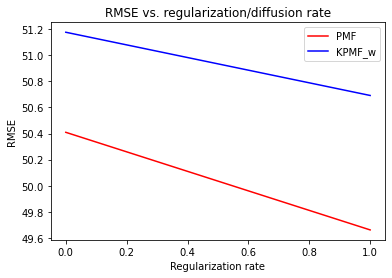

In [47]:
colors=['r','b','g','c','m','k']
plot.figure()
#bs,RMSEs = zip(*PMF_RMSE)
ws,bRMSEs = zip(*KPMF_RMSE)
labels=["PMF"]+["KPMF_"+"w" for w in ws]
plot.title("RMSE vs. regularization/diffusion rate")
for err,col,lbl in zip(bRMSEs,colors,labels): #((RMSEs,)+bRMSEs,colors,labels):
    plot.plot(err, col, label=str(lbl))#(bs, err, col, label=str(lbl))
plot.xlabel('Regularization rate')
plot.ylabel('RMSE')
plot.legend()
plot.savefig("reg_rate_and_diffusion_RMSE.png")

# Partie 3 : Sorties du modèle

# Partie 4 : Présentation des résultats